In [2]:
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
from utils.data.datasets import ModelParamsDataset
import wandb
from utils.config import config as cfg

from utils.model.models import MLP
from utils.data.helpers import list_to_model, get_moons_dataset, rotate
from utils.visualization.visualize import plot_decision_boundary

import pandas as pd

In [3]:
class ModelParamsDataset2(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        # self.dataset = self.dataset.iloc[:10000]
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx]/self.angle_change, dtype=torch.int64)
        angle = torch.nn.functional.one_hot(angle, num_classes=int(360/self.angle_change)).float()

        return weights, angle
    
    def normalize(self):
        self.max_weight = self.weights.max().max()
        self.min_weight = self.weights.min().min()
        self.weights = (self.weights - self.min_weight) / (self.max_weight - self.min_weight)
        return self.min_weight, self.max_weight

    def denormalize(self, weights):
        return weights * (self.max_weight - self.min_weight) + self.min_weight


def get_accuracy(model, X, y):
    y_pred = model(torch.tensor(X).float()).squeeze().round().detach().numpy()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    return accuracy

### Variational Autoencoder to generate weights

In [35]:
def reparameterize(mean, var):
    std = torch.exp(0.5*var)
    eps = torch.randn_like(std)
    return mean + eps*std

In [36]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(151, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU()
        )
        self.fc_mean = torch.nn.Linear(50, 10)
        self.fc_var = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = self.encoder(x)
        mean = self.fc_mean(x)
        var = self.fc_var(x)

        return mean, var
    

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 151),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mean, var  = self.encoder(x)
        x = reparameterize(mean, var)
        x = self.decoder(x)
        return x, mean, var
        


In [37]:
def total_loss_function(x, x_hat, mean, var):
    reconstruction_loss = nn.MSELoss()(x_hat, x)
    kl_divergence = -0.5 * torch.sum(1 + var - mean.pow(2) - var.exp())
    return reconstruction_loss + kl_divergence

In [38]:
dataset = ModelParamsDataset("../data/eight_angles.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# Model 
encoder = Encoder()
decoder = Decoder()
autoencoder = VariationalAutoencoder(encoder, decoder)
autoencoder.to(device)

# Hyperparameters
epochs = 100
learning_rate = 0.001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for X, y in dataloader:
        X = X.to(device)
        pred, mean, var = autoencoder(X)
        loss = total_loss_function(X, pred, mean, var)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}: Loss: {total_loss}")

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Autoencoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(151, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(32),
            torch.nn.Linear(32, 10),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 32),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(32),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64, 151),
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
import pandas as pd

class ModelParamsDataset2(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        # self.dataset = self.dataset.iloc[:10000]
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"])
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].astype('float32').values)
        angle = torch.tensor(self.angles.iloc[idx]/self.angle_change, dtype=torch.int64)
        angle = torch.nn.functional.one_hot(angle, num_classes=int(360/self.angle_change)).float()

        return weights, angle

In [ ]:
config = {
    "model":{
        "name": "Autoencoder with batchnorm",
        "layers": [151, 64, 32, 10]
    },
    "hyperparameters":{
        "epochs": 500,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]


encoder = Encoder()
decoder = Decoder()
model = Autoencoder(encoder, decoder)
model.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

wandb_config = cfg.load_env()
wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder")

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # wandb.log({"loss": loss.item()})
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

# wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: Loss: 0.6856549978256226
Epoch 2: Loss: 0.6568479537963867
Epoch 3: Loss: 0.6603942513465881
Epoch 4: Loss: 0.6277378797531128
Epoch 5: Loss: 0.6524161100387573
Epoch 6: Loss: 0.6357901692390442
Epoch 7: Loss: 0.620259165763855
Epoch 8: Loss: 0.6248916983604431
Epoch 9: Loss: 0.6157881617546082
Epoch 10: Loss: 0.6275361180305481
Epoch 11: Loss: 0.6184521317481995
Epoch 12: Loss: 0.6389187574386597
Epoch 13: Loss: 0.6336418390274048
Epoch 14: Loss: 0.6199688911437988
Epoch 15: Loss: 0.6175229549407959
Epoch 16: Loss: 0.6256035566329956
Epoch 17: Loss: 0.6075537800788879
Epoch 18: Loss: 0.6203482151031494
Epoch 19: Loss: 0.6300367712974548
Epoch 20: Loss: 0.6166913509368896
Epoch 21: Loss: 0.6298642158508301
Epoch 22: Loss: 0.6314112544059753
Epoch 23: Loss: 0.6156005859375
Epoch 24: Loss: 0.6150078773498535
Epoch 25: Loss: 0.6261707544326782
Epoch 26: Loss: 0.6217164397239685
Epoch 27: Loss: 0.6181477308273315
Epoch 28: Loss: 0.6285056471824646
Epoch 29: Loss: 0.623243927955627

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

latent = []
angles = []

model.eval()
for i in tqdm(range(len(dataset))):
    X, y = dataset[i]
    X = X.unsqueeze(0).to(device)
    pred = model.encoder(X)
    latent.append(pred.cpu().detach().numpy())
    angles.append(y.cpu().detach().numpy())

latent = np.array(latent).reshape(-1, 10)
angles = np.array(angles).reshape(-1, 8)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(latent)
plt.scatter(X_pca[:,0], X_pca[:,1], c=angles.dot([0, 45, 90, 135, 180, 225, 270, 315]))
plt.colorbar()
plt.show()

  0%|          | 0/80000 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'dot'

### Transformers

In [ ]:
class TransformerAutoencoder(nn.Module):
    def __init__(self):
        super(TransformerAutoencoder, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=33, nhead=1, batch_first=True)
        self.decoder = nn.TransformerDecoderLayer(d_model=33, nhead=1, batch_first=True)
    
    def forward(self, x):
        x = self.encoder(x)
        input = torch.zeros_like(x)
        x = self.decoder(input, x)
        return x

In [ ]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    "model":{
        "name": "TransformerAutoencoder",
        "layers": [151, 151]
    },
    "hyperparameters":{
        "epochs": 30,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

model = TransformerAutoencoder()
model.to(device)

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Loss: 4.99525260925293
Epoch 2: Loss: 4.975735664367676
Epoch 3: Loss: 4.981629371643066
Epoch 4: Loss: 4.971961498260498
Epoch 5: Loss: 4.9648237228393555
Epoch 6: Loss: 4.816472053527832
Epoch 7: Loss: 4.8884806632995605
Epoch 8: Loss: 4.931244850158691
Epoch 9: Loss: 4.893533706665039
Epoch 10: Loss: 5.033367156982422
Epoch 11: Loss: 4.912569999694824
Epoch 12: Loss: 5.01386833190918
Epoch 13: Loss: 4.947145462036133
Epoch 14: Loss: 4.906704425811768
Epoch 15: Loss: 5.014739990234375
Epoch 16: Loss: 4.971467018127441
Epoch 17: Loss: 4.987456321716309
Epoch 18: Loss: 4.964644908905029
Epoch 19: Loss: 4.945905685424805
Epoch 20: Loss: 4.921156406402588
Epoch 21: Loss: 4.9771342277526855
Epoch 22: Loss: 4.973222255706787
Epoch 23: Loss: 4.990212917327881
Epoch 24: Loss: 4.860767364501953
Epoch 25: Loss: 5.0125226974487305
Epoch 26: Loss: 4.871885299682617
Epoch 27: Loss: 4.950069904327393
Epoch 28: Loss: 4.990350246429443
Epoch 29: Loss: 5.03209924697876
Epoch 30: Loss: 4.9595

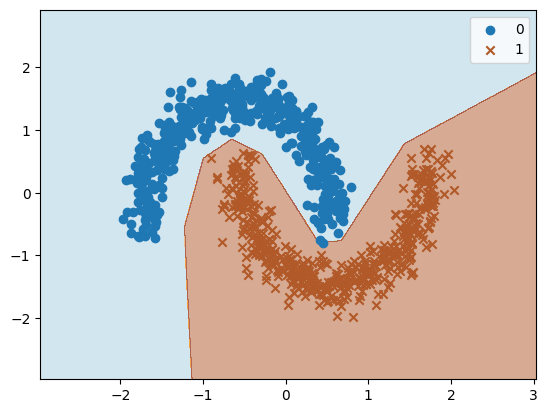

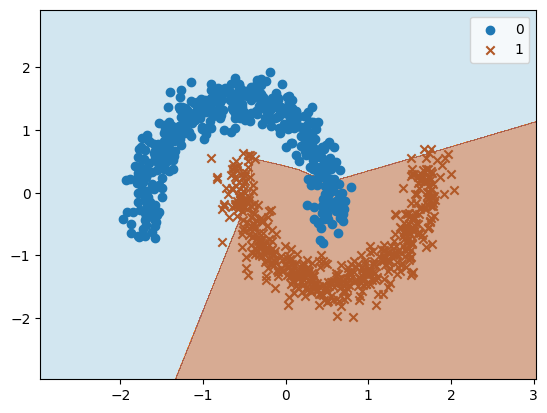

In [ ]:
m = MLP(2, [8], 1)
weights, angle = dataset[1000]
list_to_model(m, weights.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(m, X, y)

model.to("cpu")
model.eval()
with torch.no_grad():
    out = model(weights.unsqueeze(0))
    list_to_model(m, out[0].tolist())
    plot_decision_boundary(m, X, y) 

### Autoencoder small

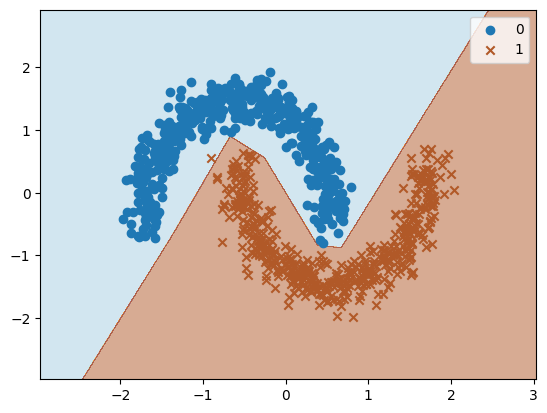

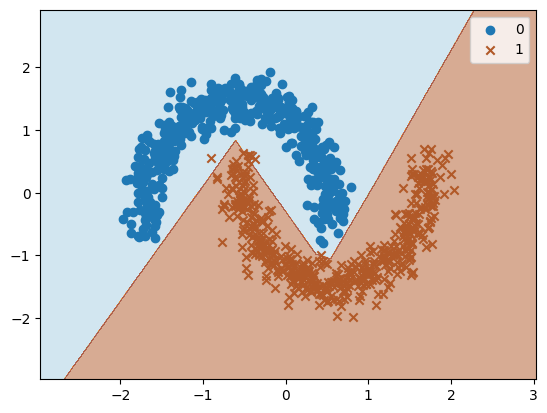

In [15]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 33),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
model = Autoencoder()
model.load_state_dict(torch.load("../models/autoencoder_small_2.pth"))

m = MLP(2, [8], 1)
weights, angle = dataset[6666]
list_to_model(m, weights.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(m, X, y)

model.to("cpu")
model.eval()
with torch.no_grad():
    out = model(weights)
    list_to_model(m, out.tolist())
    plot_decision_boundary(m, X, y) 

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: Loss: 3.043456792831421
Epoch 2: Loss: 2.7586610317230225
Epoch 3: Loss: 2.3052096366882324
Epoch 4: Loss: 2.170849323272705
Epoch 5: Loss: 2.0670547485351562
Epoch 6: Loss: 1.9729697704315186
Epoch 7: Loss: 1.896005630493164
Epoch 8: Loss: 1.7880066633224487
Epoch 9: Loss: 1.700648546218872
Epoch 10: Loss: 1.6202454566955566
Epoch 11: Loss: 1.6379233598709106
Epoch 12: Loss: 1.6244230270385742
Epoch 13: Loss: 1.4612363576889038
Epoch 14: Loss: 1.5616028308868408
Epoch 15: Loss: 1.4890844821929932
Epoch 16: Loss: 1.4184677600860596
Epoch 17: Loss: 1.4094380140304565
Epoch 18: Loss: 1.4784038066864014
Epoch 19: Loss: 1.3580766916275024
Epoch 20: Loss: 1.2654407024383545
Epoch 21: Loss: 1.2078465223312378
Epoch 22: Loss: 1.324854850769043
Epoch 23: Loss: 1.2393375635147095
Epoch 24: Loss: 1.2348905801773071
Epoch 25: Loss: 1.2192344665527344
Epoch 26: Loss: 1.1924766302108765
Epoch 27: Loss: 1.1988186836242676
Epoch 28: Loss: 1.2341911792755127
Epoch 29: Loss: 1.158052682876587


loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.35493


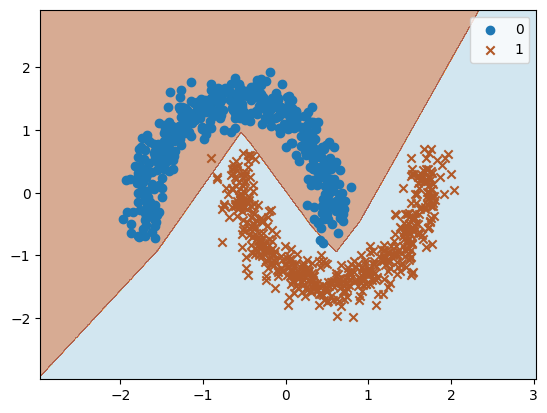

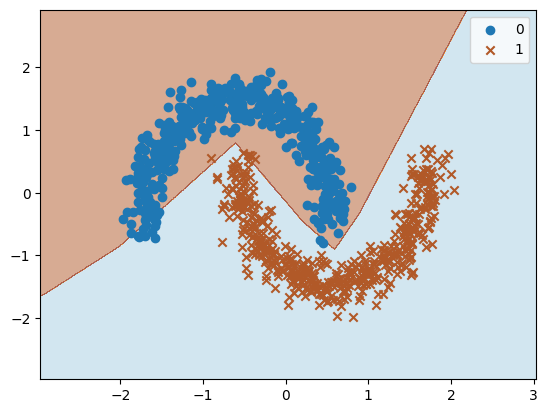

In [425]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 10),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 33),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


config = {
    "model":{
        "name": "Autoencoder small",
        "layers": [33, 512, 256, 64, 16, 10]
    },
    "hyperparameters":{
        "epochs": 500,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

wandb_config = cfg.load_env()
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder_small")

torch.manual_seed(0)
model = Autoencoder()
model.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({"loss": loss.item()})
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
model_path = "../models/autoencoder_small.pth"
torch.save(model.state_dict(), model_path)
model_artifact = wandb.Artifact(f"autoencoder", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)
wandb.finish()

m = MLP(2, [8], 1)
weights, angle = dataset[22311]
list_to_model(m, weights.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(m, X, y)

model.to("cpu")
model.eval()
with torch.no_grad():
    out = model(weights)
    list_to_model(m, out.tolist())
    plot_decision_boundary(m, X, y) 

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: Loss: 2.6701250076293945
Epoch 2: Loss: 2.440526247024536
Epoch 3: Loss: 2.1933650970458984
Epoch 4: Loss: 2.1965272426605225
Epoch 5: Loss: 2.130849838256836
Epoch 6: Loss: 2.043403148651123
Epoch 7: Loss: 1.9110029935836792
Epoch 8: Loss: 1.8206641674041748
Epoch 9: Loss: 1.9958195686340332
Epoch 10: Loss: 1.8600906133651733
Epoch 11: Loss: 1.9690302610397339
Epoch 12: Loss: 1.873859167098999
Epoch 13: Loss: 1.8097765445709229
Epoch 14: Loss: 1.7069857120513916
Epoch 15: Loss: 1.7682735919952393
Epoch 16: Loss: 1.8080788850784302
Epoch 17: Loss: 1.735247254371643
Epoch 18: Loss: 1.7320619821548462
Epoch 19: Loss: 1.705016851425171
Epoch 20: Loss: 1.691263198852539
Epoch 21: Loss: 1.7053951025009155
Epoch 22: Loss: 1.6955831050872803
Epoch 23: Loss: 1.6975181102752686
Epoch 24: Loss: 1.686096429824829
Epoch 25: Loss: 1.5130656957626343
Epoch 26: Loss: 1.6033633947372437
Epoch 27: Loss: 1.5897201299667358
Epoch 28: Loss: 1.6785269975662231
Epoch 29: Loss: 1.6231398582458496
Ep

loss,█▇▆▆▅▄▄▃▃▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.36341


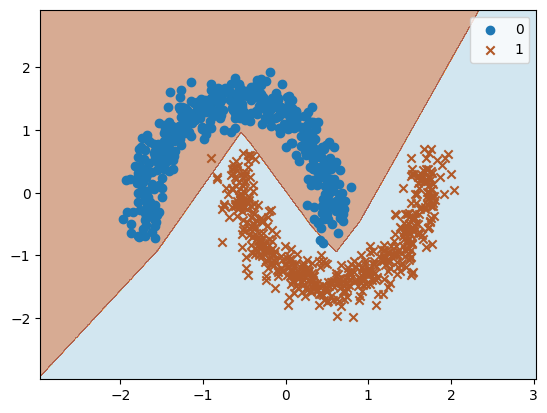

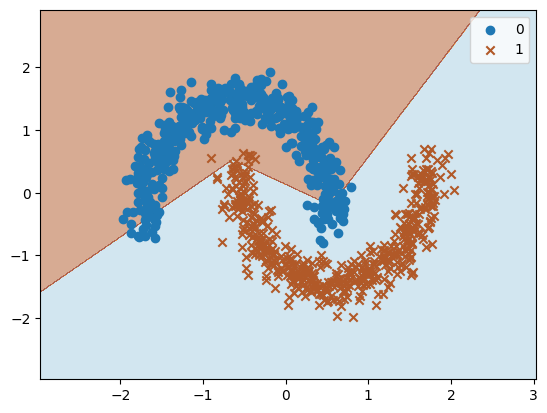

In [426]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 33),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


config = {
    "model":{
        "name": "Autoencoder small",
        "layers": [33, 256, 64, 10]
    },
    "hyperparameters":{
        "epochs": 500,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

wandb_config = cfg.load_env()
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder_small")

torch.manual_seed(0)
model = Autoencoder()
model.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({"loss": loss.item()})
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
model_path = "../models/autoencoder_small.pth"
torch.save(model.state_dict(), model_path)
model_artifact = wandb.Artifact(f"autoencoder", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)
wandb.finish()

m = MLP(2, [8], 1)
weights, angle = dataset[22311]
list_to_model(m, weights.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(m, X, y)

model.to("cpu")
model.eval()
with torch.no_grad():
    out = model(weights)
    list_to_model(m, out.tolist())
    plot_decision_boundary(m, X, y) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Loss: 2.4128241539001465
Epoch 2: Loss: 2.2866051197052
Epoch 3: Loss: 2.1337974071502686
Epoch 4: Loss: 2.1929378509521484
Epoch 5: Loss: 2.0866265296936035
Epoch 6: Loss: 1.9320858716964722
Epoch 7: Loss: 1.9879800081253052
Epoch 8: Loss: 1.883954405784607
Epoch 9: Loss: 1.9341872930526733
Epoch 10: Loss: 1.9214452505111694
Epoch 11: Loss: 1.9202207326889038
Epoch 12: Loss: 1.8546332120895386
Epoch 13: Loss: 1.9764893054962158
Epoch 14: Loss: 1.7533557415008545
Epoch 15: Loss: 1.849657416343689
Epoch 16: Loss: 1.93436861038208
Epoch 17: Loss: 1.7108190059661865
Epoch 18: Loss: 1.7399710416793823
Epoch 19: Loss: 1.7465503215789795
Epoch 20: Loss: 1.7503035068511963
Epoch 21: Loss: 1.6946841478347778
Epoch 22: Loss: 1.7068027257919312
Epoch 23: Loss: 1.729038119316101
Epoch 24: Loss: 1.7839456796646118
Epoch 25: Loss: 1.6194877624511719
Epoch 26: Loss: 1.6319414377212524
Epoch 27: Loss: 1.6296573877334595
Epoch 28: Loss: 1.6572943925857544
Epoch 29: Loss: 1.7415194511413574
Ep

loss,█▆▇▆▅▄▅▄▄▃▄▄▃▃▃▂▂▃▃▃▂▃▃▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▂▁
loss,0.85046


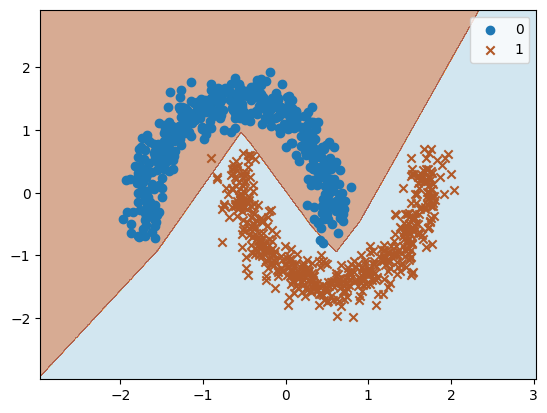

ValueError: expected 2D or 3D input (got 1D input)

In [17]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64, 10),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 33),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


config = {
    "model":{
        "name": "Skilled Terrain with batchnorm",
        "layers": [33, 256, 64, 10]
    },
    "hyperparameters":{
        "epochs": 300,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

wandb_config = cfg.load_env()
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder_small")

torch.manual_seed(0)
model = Autoencoder()
model.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({"loss": loss.item()})
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
model_path = "../models/autoencoder_small.pth"
torch.save(model.state_dict(), model_path)
model_artifact = wandb.Artifact(f"autoencoder", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)
wandb.finish()

m = MLP(2, [8], 1)
weights, angle = dataset[22311]
list_to_model(m, weights.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(m, X, y)

model.to("cpu")
model.eval()
with torch.no_grad():
    out = model(weights)
    list_to_model(m, out.tolist())
    plot_decision_boundary(m, X, y) 

In [402]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [404]:
config = {
    "model":{
        "name": "Autoencoder small",
        "layers": [33, 128, 64, 10]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

wandb_config = cfg.load_env()
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder_small")

torch.manual_seed(0)
model = Autoencoder()
model.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({"loss": loss.item()})
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
model_path = "../models/autoencoder_small.pth"
torch.save(model.state_dict(), model_path)
model_artifact = wandb.Artifact(f"autoencoder", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)
wandb.finish()

wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Loss: 2.784048080444336
Epoch 2: Loss: 2.6662418842315674
Epoch 3: Loss: 2.5357046127319336
Epoch 4: Loss: 2.30082106590271
Epoch 5: Loss: 2.2194292545318604
Epoch 6: Loss: 2.178677797317505
Epoch 7: Loss: 2.1040029525756836
Epoch 8: Loss: 2.1613566875457764
Epoch 9: Loss: 2.046699285507202
Epoch 10: Loss: 2.1346967220306396
Epoch 11: Loss: 2.009110927581787
Epoch 12: Loss: 2.008732795715332
Epoch 13: Loss: 1.9587173461914062
Epoch 14: Loss: 2.0510122776031494
Epoch 15: Loss: 1.9276580810546875
Epoch 16: Loss: 2.0754311084747314
Epoch 17: Loss: 1.796669840812683
Epoch 18: Loss: 1.8354754447937012
Epoch 19: Loss: 1.8706563711166382
Epoch 20: Loss: 1.887431263923645
Epoch 21: Loss: 1.888121485710144
Epoch 22: Loss: 2.0429184436798096
Epoch 23: Loss: 1.7144663333892822
Epoch 24: Loss: 1.8020734786987305
Epoch 25: Loss: 1.7718709707260132
Epoch 26: Loss: 1.7504205703735352
Epoch 27: Loss: 1.6455042362213135
Epoch 28: Loss: 1.6977664232254028
Epoch 29: Loss: 1.767817497253418
Epoch

loss,█▇▆▆▅▅▆▅▅▅▅▄▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
loss,0.6486


In [412]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
model.train()
model.to(device)
for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Loss: 0.5869203209877014
Epoch 2: Loss: 0.6461732983589172
Epoch 3: Loss: 0.6112393140792847
Epoch 4: Loss: 0.6826441287994385
Epoch 5: Loss: 0.6473104953765869
Epoch 6: Loss: 0.691757321357727
Epoch 7: Loss: 0.5758547782897949
Epoch 8: Loss: 0.6496739387512207
Epoch 9: Loss: 0.5897079706192017
Epoch 10: Loss: 0.5469454526901245
Epoch 11: Loss: 0.613582968711853
Epoch 12: Loss: 0.6238091588020325
Epoch 13: Loss: 0.6102802157402039
Epoch 14: Loss: 0.6248224377632141
Epoch 15: Loss: 0.6366756558418274
Epoch 16: Loss: 0.6230995059013367
Epoch 17: Loss: 0.6578724384307861
Epoch 18: Loss: 0.5836257934570312
Epoch 19: Loss: 0.5243451595306396
Epoch 20: Loss: 0.6489031314849854
Epoch 21: Loss: 0.6329386830329895
Epoch 22: Loss: 0.5907202363014221
Epoch 23: Loss: 0.5429607033729553
Epoch 24: Loss: 0.6564424633979797
Epoch 25: Loss: 0.5808531641960144
Epoch 26: Loss: 0.6144145727157593
Epoch 27: Loss: 0.6126877665519714
Epoch 28: Loss: 0.595354437828064
Epoch 29: Loss: 0.58311682939529

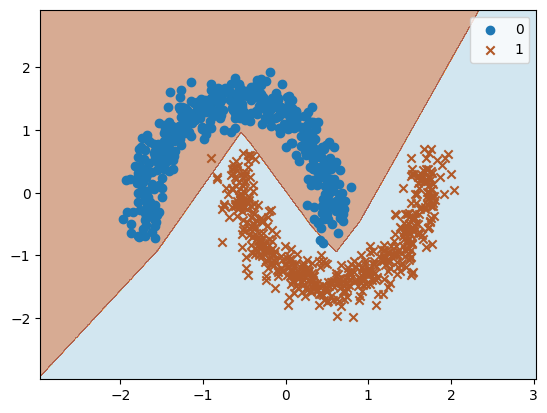

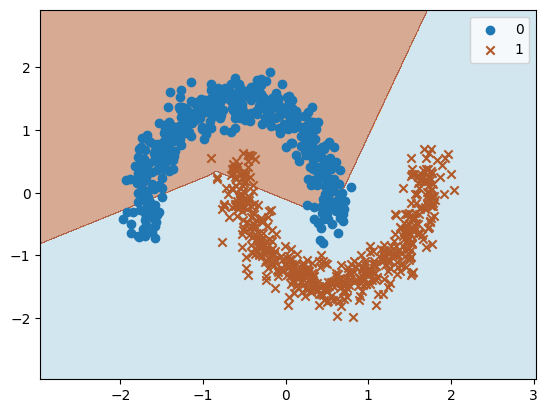

In [413]:
m = MLP(2, [8], 1)
weights, angle = dataset[22311]
list_to_model(m, weights.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(m, X, y)

model.to("cpu")
model.eval()
with torch.no_grad():
    out = model(weights)
    list_to_model(m, out.tolist())
    plot_decision_boundary(m, X, y) 

In [ ]:
from utils.data.helpers import rotate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Stopped training at epoch: 2
99.2


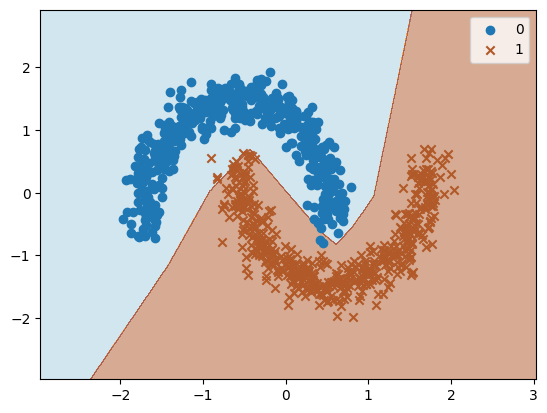

In [ ]:
m = MLP(2, [8], 1)
m.to(device)
X, y = get_moons_dataset(1000, 0.1)
weights, angle = dataset[1200]
out = model(weights)
list_to_model(m, out.tolist())

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.05)
X_rotated = rotate(X, 0)
X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

m.train()
for epoch in range(1000):
    m.train()
    m.to(device)
    optimizer.zero_grad()
    y_pred = m(X_tensor).flatten()
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

    m.eval()
    m.to("cpu")
    accuracy = get_accuracy(m, X, y)
    if(accuracy > 99):
        print("Stopped training at epoch:", epoch)
        break

print(get_accuracy(m, X, y))
plot_decision_boundary(m, X, y)

## Projection

In [ ]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 16),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(8),
            torch.nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 8),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(8),
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16),
            torch.nn.Linear(16, 33)
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder2(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder2, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
config = {
    "model":{
        "name": "Autoencoder small with batchnorm",
        "layers": [33, 16, 8, 2]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]


encoder = Encoder2()
decoder = Decoder2()
model = Autoencoder2(encoder, decoder)
model.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# wandb_config = cfg.load_env()
# wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder")

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # wandb.log({"loss": loss.item()})
    print(f"Epoch {epoch+1}: Loss: {loss.item()}")

# wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
# wandb.finish()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Loss: 4.524479866027832
Epoch 2: Loss: 4.303749084472656
Epoch 3: Loss: 4.535054683685303
Epoch 4: Loss: 4.24053430557251
Epoch 5: Loss: 4.410211086273193
Epoch 6: Loss: 4.31292724609375
Epoch 7: Loss: 4.343537330627441
Epoch 8: Loss: 4.297784328460693
Epoch 9: Loss: 4.262441635131836
Epoch 10: Loss: 4.246500015258789
Epoch 11: Loss: 4.218719482421875
Epoch 12: Loss: 4.241344928741455
Epoch 13: Loss: 4.223020553588867
Epoch 14: Loss: 4.287302017211914
Epoch 15: Loss: 4.226526737213135
Epoch 16: Loss: 4.21867561340332
Epoch 17: Loss: 4.216132640838623
Epoch 18: Loss: 4.156768321990967
Epoch 19: Loss: 4.153915882110596
Epoch 20: Loss: 4.126526832580566
Epoch 21: Loss: 4.195276737213135
Epoch 22: Loss: 4.1307759284973145
Epoch 23: Loss: 4.119270324707031
Epoch 24: Loss: 4.2866082191467285
Epoch 25: Loss: 4.055174827575684
Epoch 26: Loss: 4.278680324554443
Epoch 27: Loss: 4.138584613800049
Epoch 28: Loss: 4.004045486450195
Epoch 29: Loss: 4.11122465133667
Epoch 30: Loss: 4.1671786

  0%|          | 0/80000 [00:00<?, ?it/s]

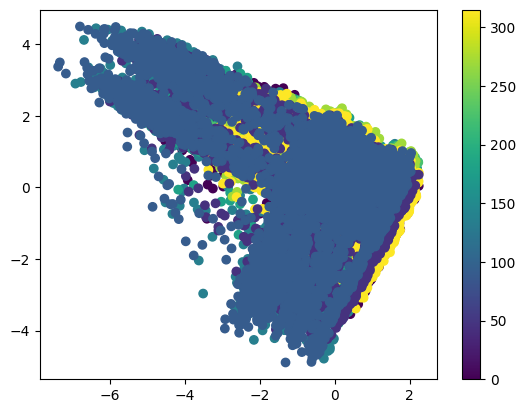

In [ ]:
latent = []
angles = []

model.eval()
for i in tqdm(range(len(dataset))):
    X, y = dataset[i]
    X = X.unsqueeze(0).to(device)
    pred = model.encoder(X)
    latent.append(pred.cpu().detach().numpy())
    angles.append(y.cpu().detach().numpy())

latent = np.array(latent).reshape(-1, 2)
angles = np.array(angles).reshape(-1, 8)
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(latent)
plt.scatter(latent[:,0], latent[:,1], c=angles.dot([0, 45, 90, 135, 180, 225, 270, 315]), cmap="viridis")
plt.colorbar()
plt.show()

## Variational Autoencoder to generate weights

In [269]:
def reparameterize(mean, var):
    std = torch.exp(0.5*var)
    eps = torch.randn_like(std)
    return mean + eps*std

class Variational(torch.nn.Module):
    def __init__(self) -> None:
        super(Variational, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 33),
            torch.nn.ReLU(),
            torch.nn.Linear(33, 33),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(33, 33),
            torch.nn.ReLU(),
            torch.nn.Linear(33, 33),
            torch.nn.Sigmoid()
        )

        self.mean = torch.nn.Linear(33, 33)
        self.var = torch.nn.Linear(33, 33)

    def forward(self, x):
        latent = self.encoder(x)
        mean = self.mean(latent)
        var = self.var(latent)
        x = reparameterize(mean, var)
        output = self.decoder(x)
        return output, mean, var

In [314]:
dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
dataset.normalize()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [313]:
variational = Variational()
loss_fn = torch.nn.functional.binary_cross_entropy
optimizer = torch.optim.Adam(variational.parameters(), lr=0.001)
device = torch.device("cuda:0")

In [315]:
epochs = 50

for i in tqdm(range(epochs)):
    for X, y in dataloader:
        output, mean, var = variational(X)

        loss = loss_fn(output, X, reduction='sum')
        kl_div = -0.5*torch.sum(1 + var - mean.pow(2) - var.exp())
        kl_div = 0
        loss += kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: {i+1}, Loss: {loss.item()}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Loss: 719.0517578125
Epoch: 2, Loss: 714.8428344726562
Epoch: 3, Loss: 711.6188354492188
Epoch: 4, Loss: 703.3255004882812
Epoch: 5, Loss: 699.9430541992188
Epoch: 6, Loss: 697.6273193359375
Epoch: 7, Loss: 698.4134521484375
Epoch: 8, Loss: 695.6114501953125
Epoch: 9, Loss: 693.902099609375
Epoch: 10, Loss: 695.1000366210938
Epoch: 11, Loss: 694.3905029296875
Epoch: 12, Loss: 692.7567138671875
Epoch: 13, Loss: 694.3946533203125
Epoch: 14, Loss: 695.7093505859375
Epoch: 15, Loss: 693.9368896484375
Epoch: 16, Loss: 694.647216796875
Epoch: 17, Loss: 693.1876220703125
Epoch: 18, Loss: 695.5792846679688
Epoch: 19, Loss: 693.012939453125
Epoch: 20, Loss: 694.791015625
Epoch: 21, Loss: 693.234619140625
Epoch: 22, Loss: 692.364990234375
Epoch: 23, Loss: 693.8012084960938
Epoch: 24, Loss: 696.3428955078125
Epoch: 25, Loss: 695.281005859375
Epoch: 26, Loss: 691.94677734375
Epoch: 27, Loss: 693.3410034179688
Epoch: 28, Loss: 693.9730224609375
Epoch: 29, Loss: 694.9754638671875
Epoch: 30

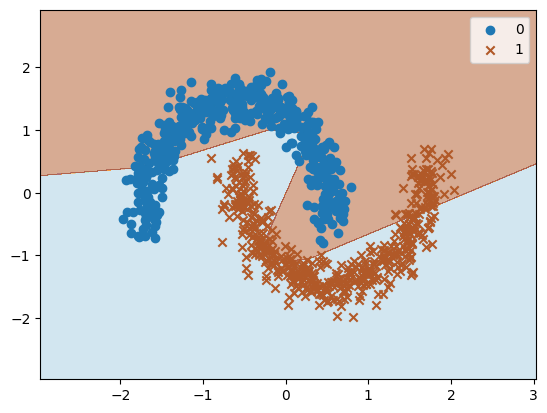

tensor([0.4555, 0.3729, 0.3238, 0.4647, 0.3324, 0.6300, 0.6309, 0.3213, 0.7718,
        0.4036, 0.4350, 0.5334, 0.6959, 0.4759, 0.4834, 0.3728, 0.5151, 0.4911,
        0.4187, 0.5044, 0.4877, 0.4461, 0.4816, 0.4598, 0.3931, 0.4309, 0.7857,
        0.3452, 0.6703, 0.3801, 0.3605, 0.3737, 0.5726])
14.499999999999998


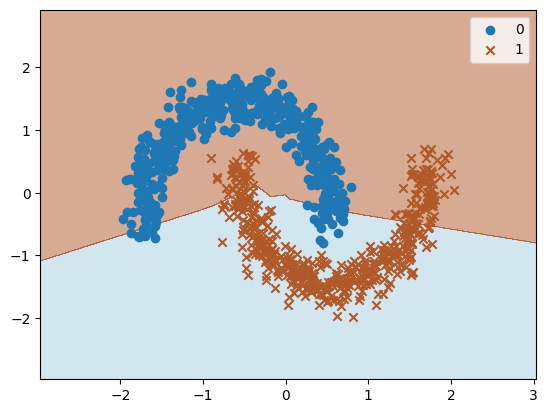

In [337]:
model = MLP(2, [8], 1)
weights, angle = dataset[35000]
w = dataset.denormalize(weights)
list_to_model(model, w.tolist())
X, y = get_moons_dataset(1000, 0.1)
plot_decision_boundary(model, X, y)

variational.eval()
with torch.no_grad():
    _, mean, var = variational(weights)
    latent = reparameterize(mean, var)
    output = variational.decoder(latent)
    w = dataset.denormalize(output)
    print(output)
    list_to_model(model, w.tolist())
    print(get_accuracy(model, X, y))
    plot_decision_boundary(model, X, y)


# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# X_rotated = rotate(X, 0)
# X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
# y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# model.train()
# model.to(device)
# for epoch in range(10000):
#     optimizer.zero_grad()
#     y_pred = model(X_tensor).flatten()
#     loss = criterion(y_pred, y_tensor)
#     loss.backward()
#     optimizer.step()

# model.to("cpu")
# print(get_accuracy(model, X, y))
# plot_decision_boundary(model, X, y)




In [334]:
weights, angle = dataset[1500]

variational.eval()
with torch.no_grad():
    _, mean, var = variational(weights)
    latent = reparameterize(mean, var)
    print(latent)
    output = variational.decoder(latent)
    print(output)

tensor([ 0.0178,  0.4178,  0.7355,  0.8165,  0.0296,  0.1464, -0.5857,  0.0973,
         0.0486,  0.1694,  0.3277, -0.2407,  0.8134, -0.1701, -0.1744,  0.7133,
        -0.4255, -0.3968,  0.2039,  0.2167, -0.2487,  0.2841,  0.5857,  0.4240,
         0.1734,  0.2660,  0.2792,  0.4777,  0.0393,  0.1898, -0.0168,  0.3656,
         0.6412])
tensor([0.5843, 0.4094, 0.4415, 0.5073, 0.4452, 0.4790, 0.7634, 0.4963, 0.7297,
        0.5670, 0.4432, 0.3699, 0.3346, 0.3784, 0.2358, 0.5736, 0.4833, 0.5244,
        0.4968, 0.4276, 0.4537, 0.5119, 0.5287, 0.4823, 0.6163, 0.4342, 0.6150,
        0.8047, 0.1911, 0.5377, 0.3142, 0.3371, 0.5332])


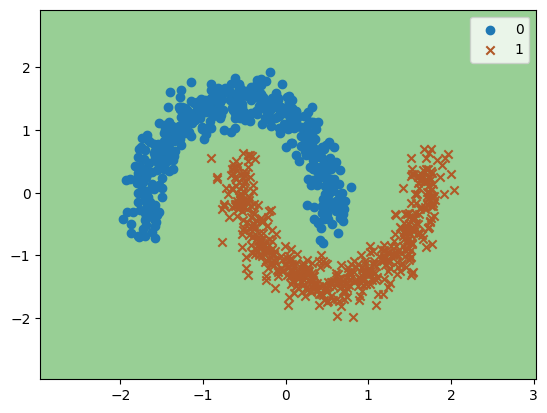

In [176]:
variational.eval()
with torch.no_grad():
    _, mean, var = variational(weights)
    latent = reparameterize(mean, var)
    output = variational.decoder(latent)
    w = dataset.denormalize(output)
    list_to_model(model, w.tolist())
    plot_decision_boundary(model, X, y) 